## Description of notebook

In this notebook, synthetic data is generated for CUB 2014 data. This dataset contains group level characteristics of students (n=248.649) that were registered to receive a college grant on 01-02-2014. Due to insufficient processing memory, 25.000 synthetic data points are generated. 

## Table of contents

0. Import libraries and data
1. Data description
2. Data cleaning
3. Correlation plot
4. Stratified sample
5. Creating metadata
6. Gaussian copula fitting
7. Evaluating produced synthetic data

## 0. Import libraries and data

In [1]:
import json
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sdv.single_table import GaussianCopulaSynthesizer
from sdmetrics.reports.single_table import QualityReport
from sklearn.model_selection import StratifiedShuffleSplit
from sdv.metadata import SingleTableMetadata, MultiTableMetadata
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sdmetrics.visualization import get_column_plot,set_plotly_config
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdmetrics.single_table import MulticlassDecisionTreeClassifier, CategoricalCAP, CategoricalEnsemble, NumericalSVR, MulticlassMLPClassifier
warnings.filterwarnings('ignore')

In [2]:
# Path to data
path = 'L:\\Werkgroepen\\Extern onderzoek Uitwonende Beurs Controle\\Algorithm Audit\\Gegevenslevering\\Werkplan extern CBS\\20240220\\Tabel1.csv'

In [3]:
# Load data
df = pd.read_csv(path, sep=";")

## 1. Data description

In [4]:
# Translate column names to EN
df = df.rename(columns={'PERSOONID': 'Person ID',
                        'ONDERWIJSVORM': 'Education',
                        'LEEFTIJD': 'Age',
                        'AFSTAND_OUDERS': 'Distance',
                        'RISICOCATEGORIE': 'Risk category',
                        'GESELECTEERD_VOOR_CONTROLE': 'Selected for control',
                        'UITKOMST_CONTROLE': 'Outcome house visit',
                        'BEZWAARPROCEDURE': 'Appeal',
                        'UITKOMST_BEZWAARPROCEDURE': 'Outcome appeal'})

In [5]:
# Translate value of columns to EN
df['Selected for control'] = df['Selected for control'].map({'Niet': 'No', 'Wel': 'Yes'})
df['Outcome house visit'] = df['Outcome house visit'].map({'Onrechtmatig': 'Unduly', 'Rechtmatig': 'Duly', 'Onbekend': 'unknown'})
df['Appeal'] = df['Appeal'].map({'Niet': 'No appeal', 'Wel': 'Appeal'})
df['Outcome appeal'] = df['Outcome appeal'].map({'Niet geslaagd': 'Unduly, appeal not successful', 'Geslaagd': 'Unduly, appeal successful', 'Deels geslaagd': 'Unduly, appeal partly successful'})

#### Data summary

In [6]:
# Missing values per column
print(df.isnull().sum())

Person ID                    0
Education                    0
Age                          0
Distance                 38657
Risk category                0
Selected for control         0
Outcome house visit     245470
Appeal                       0
Outcome appeal          247726
dtype: int64


In [7]:
# Shape of dataframe
print(df.shape)

(248649, 9)


In [8]:
# Preview of data
display(df.head())

,Person ID,Education,Age,Distance,Risk category,Selected for control,Outcome house visit,Appeal,Outcome appeal
0,72,HBO,21-22,50-500km,5,No,NaN,No appeal,NaN
1,82,MBO 3-4,19-20,10-20km,3,No,NaN,No appeal,NaN
2,955,HBO,25-50,1m-1km,2,No,NaN,No appeal,NaN
3,1078,WO,23-24,50-500km,5,No,NaN,No appeal,NaN
4,1081,WO,23-24,50-500km,5,No,NaN,No appeal,NaN


In [9]:
# Overview of all columns types
df.dtypes

Person ID                int64
Education               object
Age                     object
Distance                object
Risk category            int64
Selected for control    object
Outcome house visit     object
Appeal                  object
Outcome appeal          object
dtype: object

## 2. Data cleaning

In [10]:
# Value counts before filling missing values
df['Distance'].value_counts(dropna=False)

Distance
50-500km    84972
20-50km     43616
NaN         38657
2-5km       20517
10-20km     19527
5-10km      16087
1m-1km      13080
1-2km       11248
0km           945
Name: count, dtype: int64

In [11]:
# Filling missing values for Distance
df['Distance'].fillna('Not available', inplace=True)

In [12]:
# Value counts after filling missing values
df['Distance'].value_counts(dropna=False)

Distance
50-500km         84972
20-50km          43616
Not available    38657
2-5km            20517
10-20km          19527
5-10km           16087
1m-1km           13080
1-2km            11248
0km                945
Name: count, dtype: int64

In [13]:
# Value counts before filling missing values
df['Outcome house visit'].value_counts()

Outcome house visit
Duly       1566
Unduly     1238
unknown     375
Name: count, dtype: int64

In [14]:
# transform risk category from numeric to categorical data
df['Risk category'] = df['Risk category'].astype('category',copy=False)

In [15]:
# Filling missing values
df['Outcome house visit'].fillna('Not available', inplace=True)

In [16]:
# Value counts after filling missing values
df['Outcome house visit'].value_counts()

Outcome house visit
Not available    245470
Duly               1566
Unduly             1238
unknown             375
Name: count, dtype: int64

In [17]:
# Value counts before filling missing values
df['Outcome appeal'].value_counts()

Outcome appeal
Unduly, appeal not successful       711
Unduly, appeal successful           194
Unduly, appeal partly successful     18
Name: count, dtype: int64

In [18]:
# Filling missing values in Appeal
df['Appeal'].fillna('No appeal', inplace=True)

In [19]:
# Value counts after filling missing values
df['Appeal'].value_counts()

Appeal
No appeal    247726
Appeal          923
Name: count, dtype: int64

In [20]:
# Removing columns selected for control, appeal and person ID
del df['Selected for control']
del df['Appeal']
del df['Person ID']

In [21]:
# Checking remaining missing values
df.isnull().sum()

Education                   0
Age                         0
Distance                    0
Risk category               0
Outcome house visit         0
Outcome appeal         247726
dtype: int64

## 3. Correlation plot

In [22]:
# Distinguish categorical and numerical columns
# Select only the categorical columns
categorical_columns = df.select_dtypes(include=['object'])

# Loop through each categorical column and print value counts
for column in categorical_columns.columns:
    print(f"Value counts for column '{column}':")
    print(df[column].value_counts())

Value counts for column 'Education':
Education
HBO        107852
WO          95655
MBO 3-4     33563
MBO 1-2     11579
Name: count, dtype: int64
Value counts for column 'Age':
Age
21-22    85675
19-20    76439
23-24    43106
25-50    26109
15-18    17320
Name: count, dtype: int64
Value counts for column 'Distance':
Distance
50-500km         84972
20-50km          43616
Not available    38657
2-5km            20517
10-20km          19527
5-10km           16087
1m-1km           13080
1-2km            11248
0km                945
Name: count, dtype: int64
Value counts for column 'Outcome house visit':
Outcome house visit
Not available    245470
Duly               1566
Unduly             1238
unknown             375
Name: count, dtype: int64
Value counts for column 'Outcome appeal':
Outcome appeal
Unduly, appeal not successful       711
Unduly, appeal successful           194
Unduly, appeal partly successful     18
Name: count, dtype: int64


## 4. Stratified sample

Create a stratified sample from the original dataset with 25.000 samples. This data will be used to create the synthetic data.

In [23]:
# Define the number of samples to have
n_samples = 20000
n_samples_form = f'{int(n_samples/1000)}' + 'k'

# Ensure df has enough rows to sample from
if len(df) < n_samples:
    raise ValueError("The dataset does not have enough samples.")

# Combine the columns to form a stratification key
stratify_cols = list(df.columns)
df['stratify_key'] = df[stratify_cols].astype(str).agg('-'.join, axis=1)

# Filter out groups with less than 2 members
value_counts = df['stratify_key'].value_counts()
sufficient_counts = value_counts[value_counts >= 2].index
df_filtered = df[df['stratify_key'].isin(sufficient_counts)]

# Recalculate n_samples based on the filtered dataset size
if len(df_filtered) < n_samples:
    raise ValueError("The filtered dataset does not have enough samples.")

# Create the stratified sample
split = StratifiedShuffleSplit(n_splits=1, test_size=n_samples, random_state=42)
for _, sample_index in split.split(df_filtered, df_filtered['stratify_key']):
    stratified_sample = df_filtered.iloc[sample_index]

# Drop the stratification key column if not needed
stratified_sample = stratified_sample.drop(columns=['stratify_key'])
df = df.drop(columns=['stratify_key'])
print(stratified_sample)

       Education    Age       Distance Risk category Outcome house visit  \
19042        HBO  21-22         5-10km             2       Not available   
203255       HBO  25-50       50-500km             5       Not available   
30144        HBO  21-22       50-500km             5       Not available   
198601       HBO  21-22  Not available             6       Not available   
203578   MBO 3-4  19-20         5-10km             2       Not available   
...          ...    ...            ...           ...                 ...   
31720         WO  23-24        20-50km             5       Not available   
9474     MBO 3-4  15-18        20-50km             4       Not available   
242299        WO  21-22  Not available             6       Not available   
235925   MBO 3-4  19-20  Not available             6       Not available   
146764        WO  25-50       50-500km             5       Not available   

       Outcome appeal  
19042             NaN  
203255            NaN  
30144          

In [24]:
# Evaluate value counts of original data to stratified sample
for column in df.columns:
    print(f'{df[[column]].value_counts(normalize = True) =}')
    print(f'{stratified_sample[[column]].value_counts(normalize = True) =}')

df[[column]].value_counts(normalize = True) =Education
HBO          0.433752
WO           0.384699
MBO 3-4      0.134981
MBO 1-2      0.046568
Name: proportion, dtype: float64
stratified_sample[[column]].value_counts(normalize = True) =Education
HBO          0.43340
WO           0.38515
MBO 3-4      0.13490
MBO 1-2      0.04655
Name: proportion, dtype: float64
df[[column]].value_counts(normalize = True) =Age  
21-22    0.344562
19-20    0.307417
23-24    0.173361
25-50    0.105003
15-18    0.069656
Name: proportion, dtype: float64
stratified_sample[[column]].value_counts(normalize = True) =Age  
21-22    0.34455
19-20    0.30740
23-24    0.17350
25-50    0.10480
15-18    0.06975
Name: proportion, dtype: float64
df[[column]].value_counts(normalize = True) =Distance     
50-500km         0.341735
20-50km          0.175412
Not available    0.155468
2-5km            0.082514
10-20km          0.078532
5-10km           0.064698
1m-1km           0.052604
1-2km            0.045236
0km         

In [25]:
# check number of samples 
len(stratified_sample)

20000

## 5. Creating metadata

Creating metadata is necessary for sdv package which we will use for the Gaussian copula. This metadata contains a representation of the column types and the type of data used.

In [4]:
# Initializing metadata generator
metadata = SingleTableMetadata()
# metadata.detect_from_dataframe(stratified_sample)

In [27]:
metadata.validate()
metadata.save_to_json(f'Tabel1_stratified_sample{n_samples_form}_metadata.json') 

## 6. Gaussian copula fitting

A copula is a multivariate CDF, with uniform distributed marginals. This means that it encapsulates the joint distribution of the data. Our goal in using a copula for synthetic data generation, is to understand the joint distribution of the data and then generate samples from that joint distribution.

The copula does not assume a specific form for the marginal distributions of each column, and allows us to seperate the estimation of the marginal distributions from that of the joint distribution. It works in two steps:

1. The marginal distribution of each column is estimated, by using a Gaussian kernel density function (gaussian_kde). The samples are then transformed to a uniform distribution by using the probability integral transformation.
2. A joint Gaussian distribution is fitted on the (pseudo) transformed samples.
By using a Gaussian copula, we are making some assumptions about the dependence structure of the data. In particular, regarding tail dependence, and how likely it is to have extreme values for the numeric variables happen at the same time.

Produce the synthetic data using a Gaussian Coupola

In [5]:
metadata.load_from_json('Table1_stratified_sample20k_metadata.json')

{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "Education": {
            "sdtype": "categorical"
        },
        "Age": {
            "sdtype": "categorical"
        },
        "Distance": {
            "sdtype": "categorical"
        },
        "Risk category": {
            "sdtype": "categorical"
        },
        "Outcome house visit": {
            "sdtype": "categorical"
        },
        "Outcome appeal": {
            "sdtype": "categorical"
        }
    }
}

In [6]:
# Produce the synthetic data using a gaussian copula
# Gaussian copula fitting
synthesizer = GaussianCopulaSynthesizer(metadata,  default_distribution="gaussian_kde")
# synthesizer.fit(stratified_sample)

Once the copula is fitted to the original data, we can sample as many synthetic data points as we want from the joint CDF.

In [9]:
# Create synthetic data and preview head
n_samples = 100
synthetic_data_GC = synthesizer.sample(num_rows=n_samples)
synthetic_data_GC.head()

NotFittedError: Error: Sampling terminated. Partial results are stored in a temporary file: .sample.csv.temp. This file will be overridden the next time you sample. Please rename the file if you wish to save these results.


In [30]:
# Store synthetic data
synthetic_data_GC.to_csv(f'Table1_SD_{n_samples_form}.csv')

## 7. Evaluating produced synthetic data 

The diagnostic reports data validity and structure. Data validity means that primary keys must be unique and non-null; continuous values in the synthetic data must adhere to the min/max range in the real data; discrete values in the synthetic data must adhere to the same categories as the real data. Data structure checks that the real and synthtetic data have the same column names.

In [31]:
# Diagnostic test to check on structure of data
diagnostic = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    metadata=metadata
)

Generating report ...
(2/2) Evaluating Data Structure: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%


The column shape checks how close the marginal distributions for the real and synthetic data are. Column pair trendschecks the statistical similarity between pairs of columns in the real and synthetic data.

In [32]:
# Check univariate and bivariate distributions
quality_report = evaluate_quality(
    df,
    synthetic_data_GC,
    metadata
)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|███████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.41it/s]

Overall Score: 88.14%

Properties:
- Column Shapes: 86.4%
- Column Pair Trends: 89.88%


In [33]:
# Univariate quality report
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,Education,TVComplement,0.995817
1,Age,TVComplement,0.992268
2,Distance,TVComplement,0.979802
3,Risk category,TVComplement,0.918911
4,Outcome house visit,TVComplement,0.988079
5,Outcome appeal,TVComplement,0.309226


For numerical columns, The KSComplement returns 1-(KS statistics) where the Kolmogorov Smirnov (KS) statistic is the maximal difference between the CDF of the variable in the original and the synthetic data. A value close to 1 represents a better fit.

For categorical columns, The TVComplement returns 1 - (TV Distance), where the Total Variation Distance measures the relative frequencies of the categories of a given variable in the original and the synthetic data. A value close to 1 represents a better fit

### 7.1 Categorical data

In [34]:
# Compare frequency categorical columns synthetic data vs real data
categorical_columns = df.select_dtypes(include=object)  # Select object type (categorical) columns

for col in categorical_columns:
    # Check if column has categories (avoid potential errors)
    fig = get_column_plot(
        real_data=df,
        synthetic_data=synthetic_data_GC,
        column_name=col,
        plot_type='bar'  # Adjust plot_type for categorical data
    )
    fig.show()  # Display the plot

In [11]:
df_sdg = pd.read_csv('Table1_SD_20k.csv')
df_sdg.head()

,Unnamed: 0,Education,Age,Distance,Risk category,Outcome house visit,Outcome appeal
0,0,MBO 3-4,19-20,5-10km,5,Not available,NaN
1,1,WO,25-50,50-500km,4,Not available,NaN
2,2,MBO 3-4,19-20,50-500km,5,Not available,NaN
3,3,WO,21-22,20-50km,6,Not available,NaN
4,4,WO,19-20,50-500km,2,Not available,NaN


<Axes: >

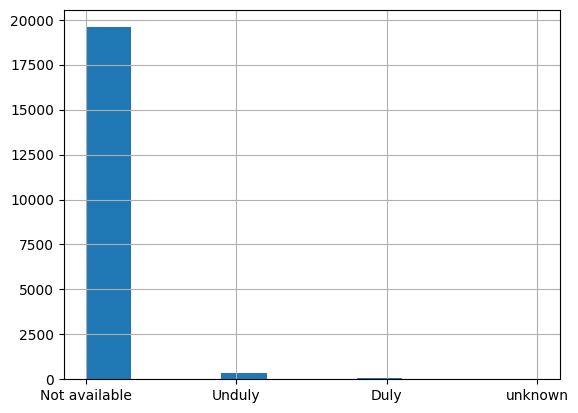

In [19]:
df_sdg['Outcome house visit'].hist()

<Axes: >

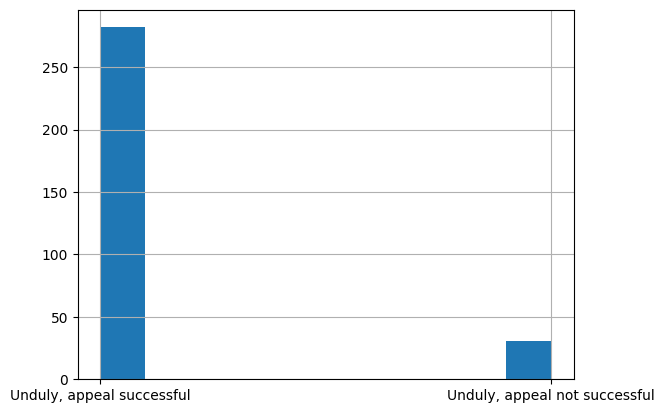

In [20]:
df_sdg['Outcome appeal'].hist()

#### 7.2 Numerical data

In [35]:
# Compare frequency numerical columns synthetic data vs real data
numerical_columns = df.select_dtypes(include=[np.number])
for col in numerical_columns:
    # Create the plot for each numerical column
    fig = get_column_plot(
        real_data=df,
        synthetic_data=synthetic_data_GC,
        column_name=col,
        plot_type='distplot'
    )
    fig.show()  # Display the plot

### Statistical tests for univariate distributions

In [36]:
df.dtypes

Education                object
Age                      object
Distance                 object
Risk category          category
Outcome house visit      object
Outcome appeal           object
dtype: object

In [39]:
from scipy.stats import ks_2samp, chi2_contingency

# Define continuous variables
continuous_vars = []

# Apply KS test to continuous variables
for column in continuous_vars:
    ks_statistic, ks_p_value = ks_2samp(df[column], synthetic_data_GC[column])
    print(f"KS Statistic for {column}: {ks_statistic}, P-value: {ks_p_value}")

In [40]:
df.columns

Index(['Education', 'Age', 'Distance', 'Risk category', 'Outcome house visit',
       'Outcome appeal'],
      dtype='object')

In [41]:
# Degfine categorical variables
categorical_vars = ['Education', 'Age', 'Distance', 'Risk category', 'Outcome house visit', 'Outcome appeal']

# Apply Chi-squared test to categorical variables
for column in categorical_vars:
    # Create a contingency table
    contingency_table = pd.crosstab(df[column], synthetic_data_GC[column])

    # Run the Chi-squared test
    chi2_stat, chi2_p, dof, ex = chi2_contingency(contingency_table)
    print(f"Chi-squared Statistic for {column}: {chi2_stat}, P-value: {chi2_p}")

Chi-squared Statistic for Education: 6.034943731847264, P-value: 0.7364159393170133
Chi-squared Statistic for Age: 13.921476741142035, P-value: 0.6045637121365757
Chi-squared Statistic for Distance: 56.409684957256914, P-value: 0.7388639674718988
Chi-squared Statistic for Risk category: 28.67181574458843, P-value: 0.2778671868513474
Chi-squared Statistic for Outcome house visit: 2.126033463564654, P-value: 0.9893140168985204
Chi-squared Statistic for Outcome appeal: 0.0, P-value: 1.0


### Multivariate checks

In [43]:
# # Create subplots for side-by-side comparison
# fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# # Plot correlation heatmap for the real dataset
# sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt=".2f", ax=axes[0])
# axes[0].set_title('Real Dataset Correlation Heatmap')

# # Plot correlation heatmap for the synthetic dataset
# sns.heatmap(synthetic_data_GC.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt=".2f", ax=axes[1])
# axes[1].set_title('Synthetic Dataset Correlation Heatmap')

# plt.tight_layout()
# plt.show()

We can observe that the correlation between the numerical columns in the original and synthetic datasets are very well preserved.

## ML efficacy

Some times, the goal of producing synthetic datasets is to solve some downstream machine learning task. This could be a classification problem in our case, so a way to test how well the synthetic datasets are is to split both the original and synthetic datasets into train and test sets. Next, we can fit the ML model to the train portion of the synthetic data and evaluate it on the test portion of the real data. If the synthetic data is close to the real data, then the capability (f1-score) of the model should be high.

In [45]:
# MulticlassMLPClassifier.compute(stratified_sample, synthetic_data_GC, target = 'RISK_SCORE')

## Privacy

First we can check if there are any rows in the original data that are found in the synthetic data

In [46]:
# Check if there are any matching rows in the two dataframes
matching_rows = df.isin(synthetic_data_GC).all(axis=1)

# Print the number of matching rows
print("Number of matching rows: ", matching_rows.sum())

Number of matching rows:  0


Next, We can imagine that an attacker already has access to some parts of the dataset. This could e.g. be access to some of the columns in the real data. If the attacker also has access to the full synthetic data, We would like to know how likely it is that they could then recover the remaining original data. It works in the following way

Identify a row (let's call it r) in the original dataset. Record all the key fields present in

Search through the synthetic dataset to find all rows that share the same key fields as r. This group of rows is referred to as the "equivalence class" of r in the synthetic data.

Within this equivalence class, each row contains synthetic values for the sensitive fields. Each of these synthetic values "votes" to guess the sensitive fields of the original row r.

Calculate the final score by determining the frequency of votes that correctly match all sensitive fields of the original row r. This score ranges between 0 and 1, indicating the accuracy of the synthetic data in replicating sensitive field values from the original dataset.

A score closer to one indicates that the the attacker is not able to correctly guess any of the sensitive values.

In [50]:
score = CategoricalCAP.compute(
    real_data= stratified_sample,
    synthetic_data=synthetic_data_GC,
    key_fields=['Age'], # the column names that the attacker already knows. 
    sensitive_fields=['Outcome house visit']  # the column names that the attacker wants to guess.
)
score

0.03176616825545697